## Notebook setup

In [151]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [94]:
conn = ConexionBD.obtener_conexion()

## Expenses analysis

**Data setup**

In [95]:
query = """
    SELECT fecha_valor, importe, saldo, categoria
    FROM bancapp.movimientos_mview
    WHERE fecha_valor > '2022-12-31'
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [96]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

In [97]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1909 entries, 0 to 2204
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  1909 non-null   datetime64[ns]
 1   mes_valor    1909 non-null   int32         
 2   anio_valor   1909 non-null   int32         
 3   importe      1909 non-null   float64       
 4   categoria    1909 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 74.6+ KB


In [98]:
df_gastos.importe.describe([.25, .5, .75, .90, .95, .99])

count    1909.000000
mean       74.557910
std       247.899444
min         0.490000
25%        10.250000
50%        27.350000
75%        71.170000
90%       200.000000
95%       301.000000
99%       499.920000
max      9000.000000
Name: importe, dtype: float64

**Outliers**

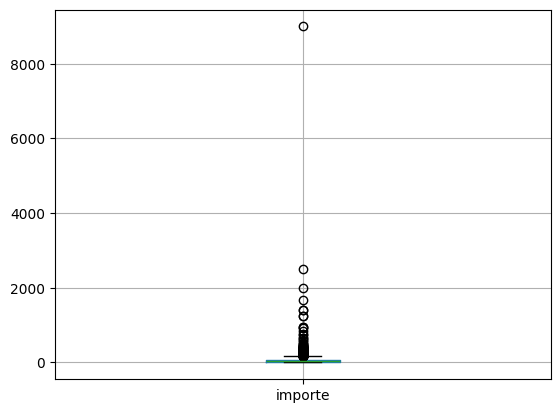

In [99]:
df_gastos.boxplot(column="importe");

In [100]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  162.55


Remove outliers

In [101]:
df_gastos_nooutliers = df_gastos[df_gastos.importe < higher_fence]

In [102]:
df_gastos_nooutliers.importe.describe([.25, .5, .75, .90, .95, .99])

count    1675.000000
mean       33.582036
std        32.708423
min         0.490000
25%         9.285000
50%        21.690000
75%        49.000000
90%        79.996000
95%       100.074000
99%       142.671600
max       160.700000
Name: importe, dtype: float64

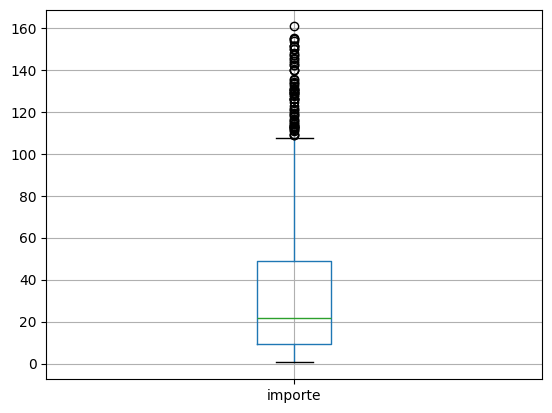

In [103]:
df_gastos_nooutliers.boxplot(column="importe");

Función para analisis de gastos por mes, año y tendencia

In [214]:
from sklearn import linear_model

def analysis_expenses_month_year_trend(df, agg_level:list[str], value_column:str) -> float:
    """Devuelve la tendencia de los gastos.
        
        Args:        
            df: dataframe con los datos.
            agg_level: lista de columnas sobre las que agrupar.
            value_column: columna sobre la que aplicar la funcion "sum" de agregacion.
    """

    # agg
    df_by_month = df.groupby(by=agg_level).agg(gasto_total=(value_column,"sum"))

    # trend
    reg = linear_model.LinearRegression()
    
    X = np.arange(0,len(df_by_month["gasto_total"])).reshape(-1, 1)
    y = df_by_month["gasto_total"].values
    
    model = reg.fit(X,y)
    tendencia = model.predict(X)

    # plot
    df_by_month.plot.bar(rot=45, figsize=(15,6), grid=True);
    plt.plot(X, tendencia, color="red")
    plt.xticks(range(len(df_by_month.gasto_total)),df_by_month.index, rotation=45)
    plt.show();

    # Print trend variation
    maximo = tendencia[-1]
    minimo = tendencia[0]
    print(f"Tendencia: min:{minimo:.0f} max:{maximo:.0f}")
    print(f"aumento: {maximo-minimo:.2f}")
    print(f"%aumento: {(maximo-minimo)/minimo:.2f}")

    return tendencia


**Expenses by month TRAMO BAJO**

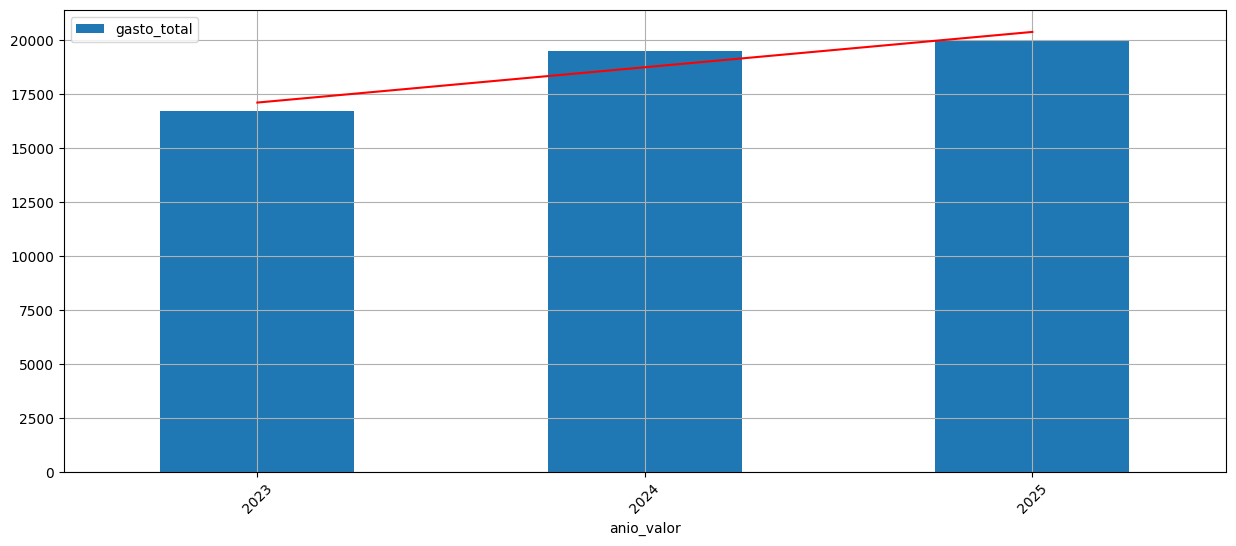

Tendencia: min:17114 max:20386
aumento: 3272.26
%aumento: 0.19


In [215]:
analysis_expenses_month_year_trend(df_gastos_nooutliers, ["anio_valor"], "importe");

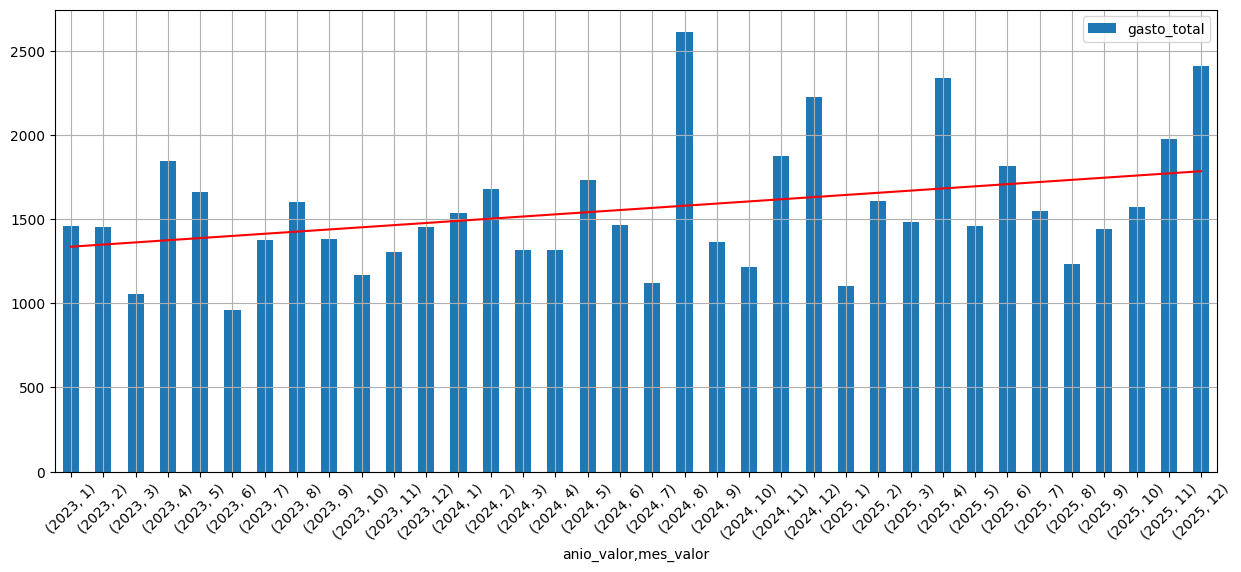

Tendencia: min:1338 max:1787
aumento: 449.24
%aumento: 0.34


In [216]:
tendencia = analysis_expenses_month_year_trend(df_gastos_nooutliers, ["anio_valor","mes_valor"], "importe")

**Outliers analysis**

In [107]:
df_gastos_outliers = df_gastos[df_gastos.importe >= higher_fence]

In [108]:
df_gastos_outliers.importe.describe([.25, .5, .75, .90, .95, .99])

count     234.000000
mean      367.868120
std       630.144022
min       163.000000
25%       203.460000
50%       263.000000
75%       336.675000
90%       446.400000
95%       800.727500
99%      1896.300800
max      9000.000000
Name: importe, dtype: float64

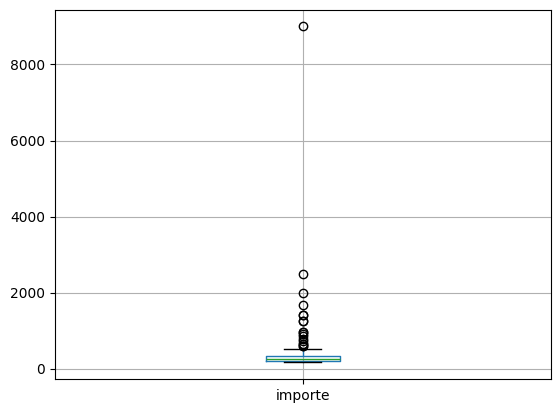

In [109]:
df_gastos_outliers.boxplot(column="importe");

Remove outliers from the outliers

In [110]:
IQR = df_gastos_outliers.importe.quantile(0.75) - df_gastos_outliers.importe.quantile(0.25)

higher_fence = df_gastos_outliers.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  536.4975


In [111]:
df_gastos_outliers_2 = df_gastos[df_gastos.importe < higher_fence]

**Expenses by month TRAMO ALTO**

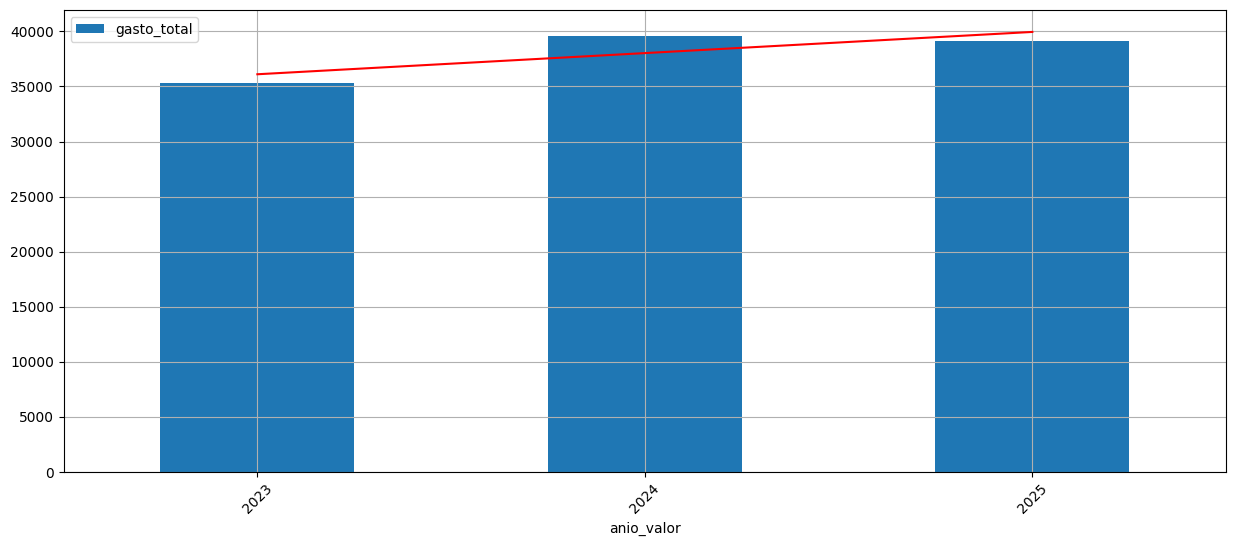

Tendencia: min:36111 max:39954
aumento: 3843.15
%aumento: 0.11


In [217]:
tendencia = analysis_expenses_month_year_trend(df_gastos_outliers_2, ["anio_valor"], "importe");

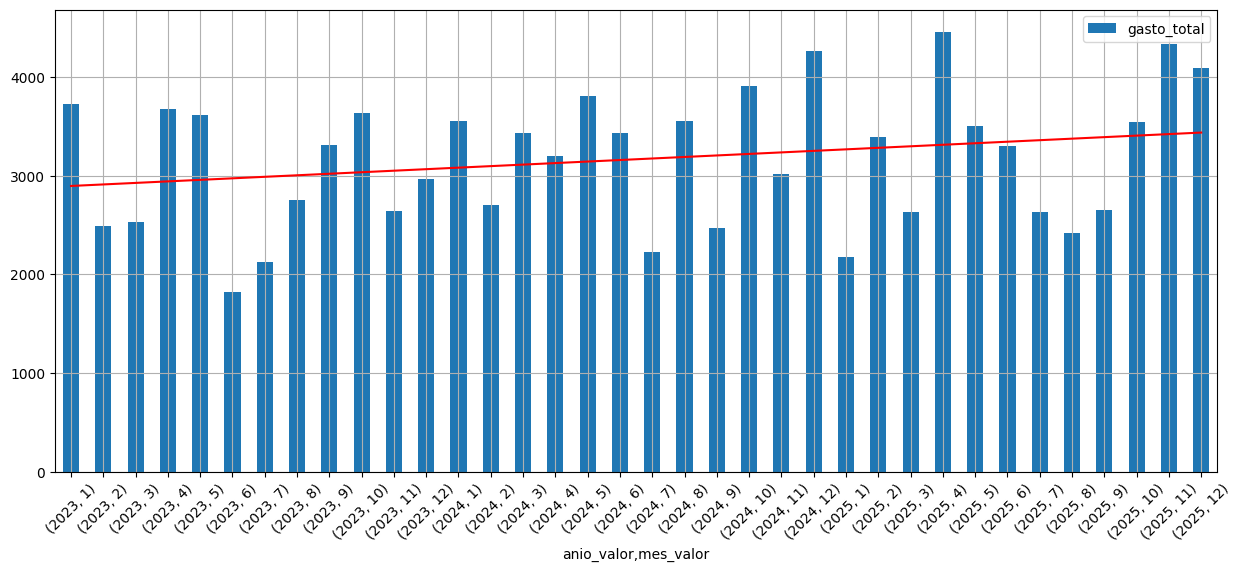

Tendencia: min:2898 max:3440
aumento: 542.06
%aumento: 0.19


In [218]:
tendencia = analysis_expenses_month_year_trend(df_gastos_outliers_2, ["anio_valor","mes_valor"], "importe");

In [114]:
minimo = float(min(tendencia))
maximo = float(max(tendencia))
print(f"Tendencia - min:{minimo:.0f} max:{maximo:.0f}")

aumento = (maximo-minimo) / minimo
print(f"% aumento: {aumento:.2f}%")

Tendencia - min:2898 max:3440
% aumento: 0.19%


## Gastos por categoria

**Tramo bajo**

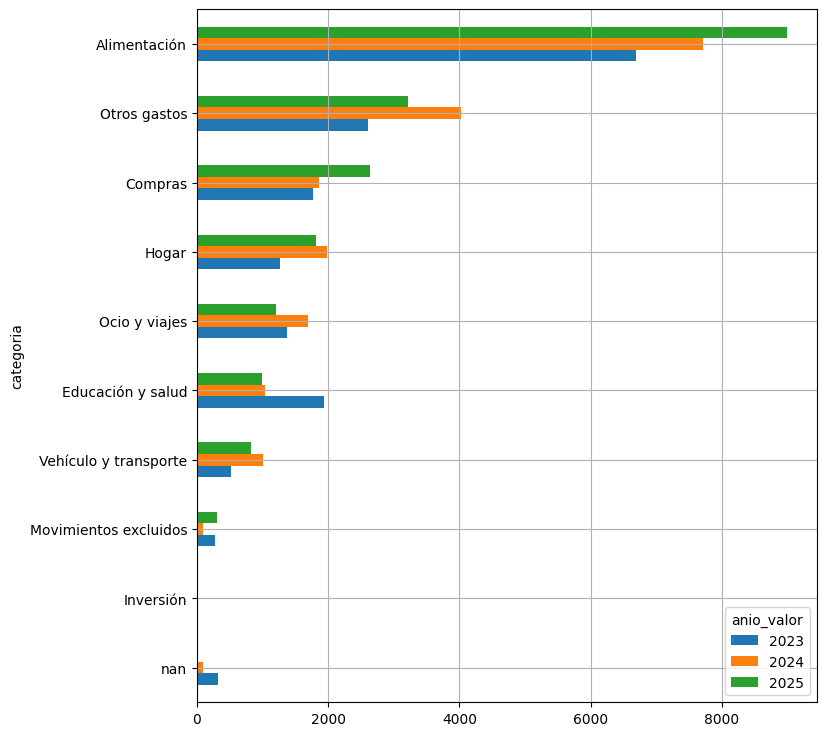

In [115]:
# Gastos por año y categoria
df_gastos_nooutliers_bycat = df_gastos_nooutliers.groupby(by=["anio_valor", "categoria"]).agg(gasto_total=("importe","sum")).reset_index()

# Pivoto por categoria y saco los años a columnas
pivot = df_gastos_nooutliers_bycat.pivot(index="categoria", columns="anio_valor", values="gasto_total").fillna(0)

pivot.sort_values(by=2025).plot.barh(grid=True, figsize=(8,9));

**Tramo alto**

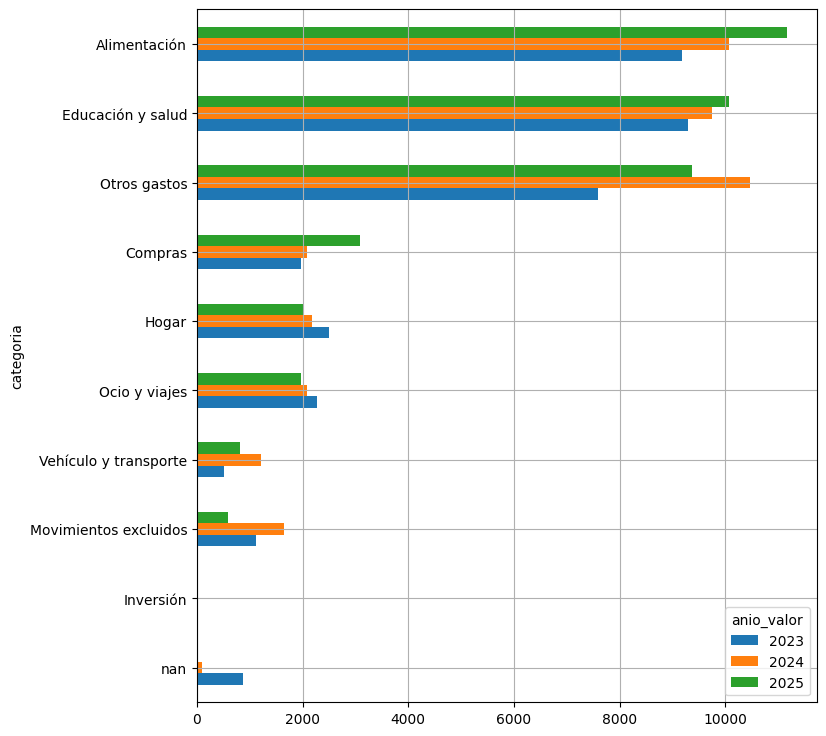

In [116]:
# Gastos por año y categoria
df_gastos_outliers_bycat = df_gastos_outliers_2.groupby(by=["anio_valor", "categoria"]).agg(gasto_total=("importe","sum")).reset_index()

# Pivoto por categoria y saco los años a columnas
pivot = df_gastos_outliers_bycat.pivot(index="categoria", columns="anio_valor", values="gasto_total").fillna(0)

pivot.sort_values(by=2025).plot.barh(grid=True, figsize=(8,9));

## Zoom en Compras

In [117]:
df_compras = df_gastos[df_gastos.categoria == "Compras"]

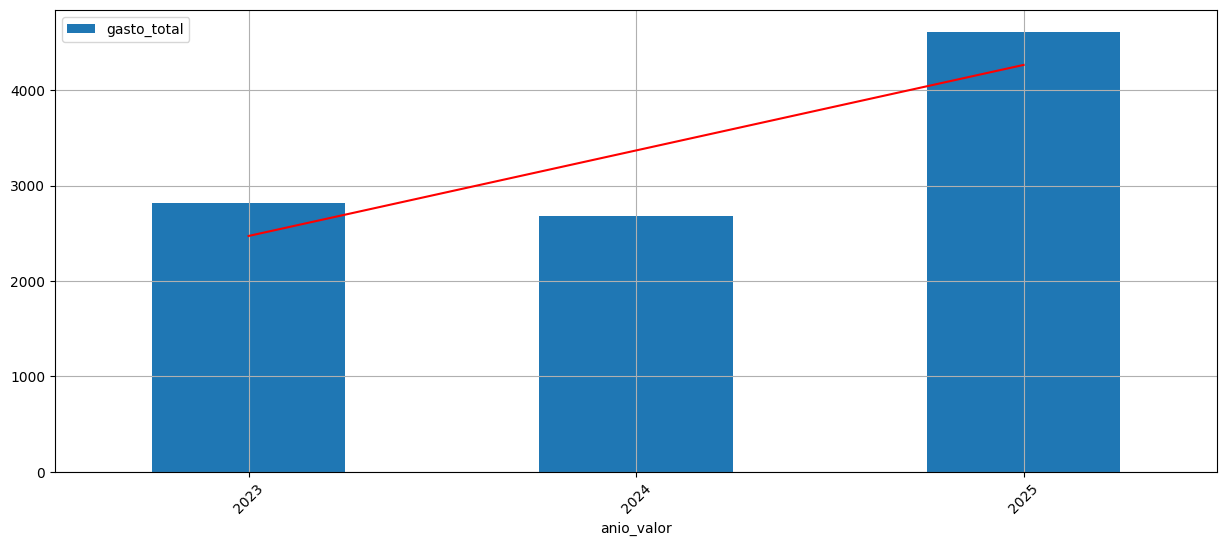

Tendencia: min:2472 max:4263
aumento: 1791.43
%aumento: 0.72


In [219]:
tendencia = analysis_expenses_month_year_trend(df_compras, ["anio_valor"], "importe")

In [269]:
df_compras25 = df_compras[df_compras.anio_valor == 2025].importe
df_compras24 = df_compras[df_compras.anio_valor == 2024].importe

In [272]:
t_stat, p_value = stats.ttest_ind(df_compras25, df_compras24)

print(t_stat, p_value)

0.9718429709030066 0.33237079143171244


p_value > 0.05, las medias son iguales No hay diferencias significativas en la media de gastos

In [273]:
plt.hist(df_compras25.importe, bins=30, histtype='step', color='blue', linewidth=1, label="2025")
plt.hist(df_compras24.importe, bins=30, histtype='step', color='red', linewidth=1, label="2024")
plt.legend()
plt.show()

AttributeError: 'Series' object has no attribute 'importe'